# 1st and 2nd analysis for BIDS
**first level analysis,second level analysis for preprocessed data from fmriprep**
<div class="altert alert-info"><h4> Information</h4>
    
 <li>Author: DongHui Song</li>
 <li>email:donghuipsy@gmail.com</li>

 <li>Homepage:https://donghui1119.github.io/donghui/</li>

In [74]:
import os
import numpy as np
import nibabel as nb
from nilearn import plotting
import matplotlib.pyplot as plt
from bids.layout import BIDSLayout
from nilearn.plotting import plot_design_matrix
from nilearn.glm.first_level import FirstLevelModel
from nilearn.glm.second_level import SecondLevelModel
from nilearn.glm.thresholding import threshold_stats_img
from nilearn.glm.first_level import first_level_from_bids

In [75]:
data_dir="/home/donghui/Public/dh_test/fmriprep/stastic/" # your preprocessed data dir
results_dirf="/home/donghui/Public/dh_test/fmriprep/results/first_level" #output dir for 1st level
results_dirs="/home/donghui/Public/dh_test/fmriprep/results/second_level" #output dir for 2nd level
mask_file="/home/donghui/Public/dh_test/fmriprep/rMNI152_T1_2mm_brain_mask.nii" # mask dir

In [76]:
layout = BIDSLayout(data_dir)
subject_list = sorted(layout.get_subjects()) # subject list
n_subject=len(subject_list) # number of  subjects
session_list = layout.get_sessions() # session list
runs = layout.get_runs() # runs list
task_id = sorted(layout.get_tasks()) # task list
# List of functional images
func_files = layout.get(datatype='func', return_type='file', extension='.nii.gz',
                        suffix='bold', task=task_id[0])
resolution = np.array([nb.load(f).header.get_zooms() for f in func_files])
# Get  TR of all collected functional images
TR = np.median(resolution[:, 3])

In [77]:
# Create an empty dictionary
content_func = {}
content_func['number_subjects']=n_subject
# List of subject identifiers
content_func['subject_list_func'] = subject_list
# List of session identifiers
content_func['session_list_func'] = session_list
# List of task identifiers
content_func['task_list'] = task_id
# List of run identifiers
content_func['run_list'] = runs
# Requested isometric voxel resolution
content_func['res_func'] = round(np.median(resolution).astype('float64'), 3)
content_func['tr_func'] = TR
content_func

{'number_subjects': 3,
 'subject_list_func': ['007', '008', '009'],
 'session_list_func': [],
 'task_list': ['emoreg', 'gambling', 'resting', 'social'],
 'run_list': [01, 02],
 'res_func': 2.0,
 'tr_func': 2.0}

In [79]:
task_label = 'social'
space_label = 'MNI152NLin2009cAsym'
derivatives_folder = 'derivatives'
models, models_run_imgs, models_events, models_confounds = \
    first_level_from_bids(
        data_dir, task_label,space_label,
        img_filters=[('desc', 'preproc')],min_onset=-5, \
    smoothing_fwhm=8,drift_model=None,hrf_model='spm', mask_img=mask_file)

/home/donghui/.local/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:901: UserWarning: SliceTimingRef not found in file /home/donghui/Public/dh_test/fmriprep/stastic/derivatives/sub-007/func/sub-007_task-social_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.json. It will be assumed that the slice timing reference is 0.0 percent of the repetition time. If it is not the case it will need to be set manually in the generated list of models
  warn('SliceTimingRef not found in file %s. It will be assumed'


In [80]:
model_and_args = zip(models, models_run_imgs, models_events, models_confounds)

for midx, (model, imgs, events, confounds) in enumerate(model_and_args):
    # fit the GLM
    model.fit(imgs, events) # model.fit(imgs, events, confounds) # adding confounds
    # compute the contrast of interest
    stat= model.compute_contrast('social-random',output_type='all')
    
    first_Pvalue=os.path.join(results_dirf+'/sub-' + model.subject_label+\
                              '_first_level_P_value.nii.gz')
    
    first_Zscore=os.path.join(results_dirf+'/sub-' + model.subject_label+\
                              '_first_level_Z_score.nii.gz')
    
    first_stat=os.path.join(results_dirf+'/sub-' + model.subject_label+\
                              '_first_level_Stat_value.nii.gz')
    
    first_effect_size=os.path.join(results_dirf+'/sub-' + model.subject_label+\
                              '_first_level_effect_size.nii.gz')
    
    first_effect_variance=os.path.join(results_dirf+'/sub-' + model.subject_label+\
                              '_first_level_effect_variance.nii.gz')
                              
    stat['p_value'].to_filename(first_Pvalue)
    stat['z_score'].to_filename(first_Zscore)
    stat['stat'].to_filename(first_stat)
    stat['effect_size'].to_filename(first_effect_size)
    stat['effect_variance'].to_filename(first_effect_variance)

/home/donghui/.local/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:657: UserWarning: One contrast given, assuming it for all 2 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)
/home/donghui/.local/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:657: UserWarning: One contrast given, assuming it for all 2 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)
/home/donghui/.local/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:657: UserWarning: One contrast given, assuming it for all 2 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


/home/donghui/.local/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:63: UserWarning: Mean values of 0 observed.The data have probably been centered.Scaling might not work as expected
  warn('Mean values of 0 observed.'
/home/donghui/.local/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:63: UserWarning: Mean values of 0 observed.The data have probably been centered.Scaling might not work as expected
  warn('Mean values of 0 observed.'


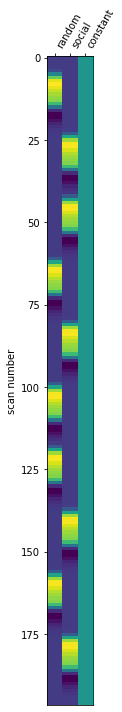

In [81]:
#plotting design matrix
first_level_model = FirstLevelModel(t_r=TR,min_onset=-5,drift_model=None)
first_level_model = first_level_model.fit(models_run_imgs[0], events=models_events[0])
design_matrix = first_level_model.design_matrices_[0]
plot_design_matrix(design_matrix)
plt.show()

In [82]:
# second level analysis
second_level_input = models

second_level_model = SecondLevelModel()
second_level_model = second_level_model.fit(second_level_input)

s_stat= second_level_model.compute_contrast(
    first_level_contrast='social-random',output_type='all')

second_Pvalue=results_dirs+'/second_level_P_value.nii.gz'
second_Zscore=results_dirs+'/second_level_Z_score.nii.gz'
second_Stat=results_dirs+'/second_level_Stat_value.nii.gz'
second_effect_size=results_dirs+'/second_level_effect_size.nii.gz'
second_effect_variance=results_dirs+'/second_level_effect_variance.nii.gz'

s_stat['p_value'].to_filename(second_Pvalue)
s_stat['z_score'].to_filename(second_Zscore)
s_stat['stat'].to_filename(second_Stat)
s_stat['effect_size'].to_filename(second_effect_size)
s_stat['effect_variance'].to_filename(second_effect_variance)

/home/donghui/.local/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:657: UserWarning: One contrast given, assuming it for all 2 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)
/home/donghui/.local/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:657: UserWarning: One contrast given, assuming it for all 2 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)
/home/donghui/.local/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:657: UserWarning: One contrast given, assuming it for all 2 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)
/home/donghui/.local/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:657: UserWarning: One contrast given, assuming it for all 2 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


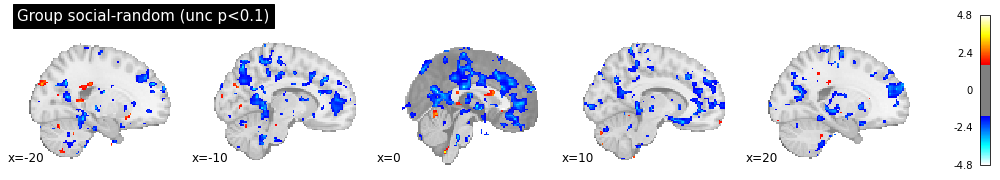

In [83]:
thresholded_map,threshold=threshold_stats_img(s_stat['z_score'],alpha=0.1,height_control='fpr')

plotting.plot_stat_map(thresholded_map, colorbar=True,threshold=threshold,
                          title='Group social-random (unc p<0.1)',
                           display_mode='x',cut_coords=[-20,-10,0,10,20])
plotting.show()